# Computer Vision (DSE/EECS-312)

This notebook is authored by **Adheesh Trivedi** This is my solutions to assignment assigned in the course EECS312 on **Aug 31st, 2024**.

## Header code

### Importing libraries

* **PIL** for image reading
* **numpy** for their advanced ndarrays, which makes writing mathematical functions over vectors and matrices a piece of cake
* **numba** for JIT compilation of the function which is used to apply filter code. This brings huge reduction in runtimes
* **matplotlib** for showing/ploting results

In [8]:
from PIL import Image
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

### Loading image

I loaded the image with `open` function provided by `Image` submodule of `PIL`

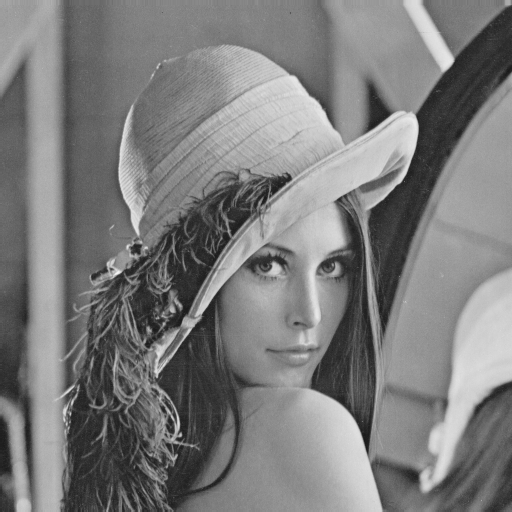

In [9]:
image = Image.open('res/lena.gif').convert('L')

image_arr = np.array(image, dtype=np.float64)

image

### Functions

I defined the functions that I will be using for application of filters and ploting the results.

In [10]:
@jit(nopython=True)
def _filter2d(image : np.ndarray, filter : np.ndarray, padding : int) -> np.ndarray:
    '''
    This function uses JIT compilation supported functions only to give
    huge boost in performance. We are talking about around 10x speedup here.
    '''

    filtered_image = np.zeros(
        (image.shape[0] - 2 * padding, image.shape[1] - 2 * padding), dtype=np.float64
    )

    for i in range(padding, image.shape[0] - padding):
        for j in range(padding, image.shape[1] - padding):
            img_chunk = image[i-padding:i+padding+1, j-padding:j+padding+1]
            filtered_image[i - padding, j - padding] = np.sum(filter * img_chunk)

    return filtered_image


def filter2d(image : np.ndarray, filter : np.ndarray) -> np.ndarray:
    '''
    This function applies a 2D square filter with odd dimensions to an image.
    '''

    if filter.shape[0] != filter.shape[1]:
        raise ValueError("Filter must be square")
    if filter.shape[0] % 2 == 0:
        raise ValueError("Filter must have odd dimensions")

    padding = filter.shape[0] // 2
    padded_image = np.pad(image, (padding, padding), mode = 'edge', )

    return _filter2d(padded_image, filter, padding)


def arr_to_img(arr : np.ndarray, absolute = True) -> Image.Image:
    '''
    Converts the array to an image, by default takes absolute value of array
    '''

    if absolute:
        arr = np.abs(arr)
    return Image.fromarray(np.uint8(arr))


def plot_images(images : list[str, Image.Image], cmap = 'gray', nrows = None, ncols = None) -> None:
    '''
    This function plots a list of images.
    One can provide nrows and ncols to specify the number of rows and columns in the plot.
    '''

    if nrows is None and ncols is None:
        nrows = 1
        ncols = len(images)

    if (nrows*ncols) < len(images):
        raise ValueError("Number of rows and columns does not fit the number of images")

    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    if nrows == 1 and ncols == 1:
        axs = np.array([axs])

    axs = axs.reshape((nrows*ncols))

    for i, (title, img) in enumerate(images):
        axs[i].imshow(img, cmap=cmap)
        axs[i].set_title(title)
        axs[i].set_axis_off()
    plt.show()

## Question 1

First I created a dictionary which will be used to store the images that we produce using filters

In [11]:
# Stor all the filtered images for first question here
filtered_images_1 = dict()

### Prewitt filter (3 by 3)

I used the $3\times3$ Prewitt filter to produce image dipicting the edges in the original image:

$$

\delta_x = 
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1\end{bmatrix}

$$

and,

$$

\delta_y = 
\begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix}

$$

In [12]:
prewitt_dx = np.array((
    (-1, 0, 1),
    (-1, 0, 1),
    (-1, 0, 1)
)) / 3.

filtered_images_1["Prewitt dx"] = filter2d(image_arr, prewitt_dx)

In [13]:
prewitt_dy = prewitt_dx.T

filtered_images_1["Prewitt dy"] = filter2d(image_arr, prewitt_dy)

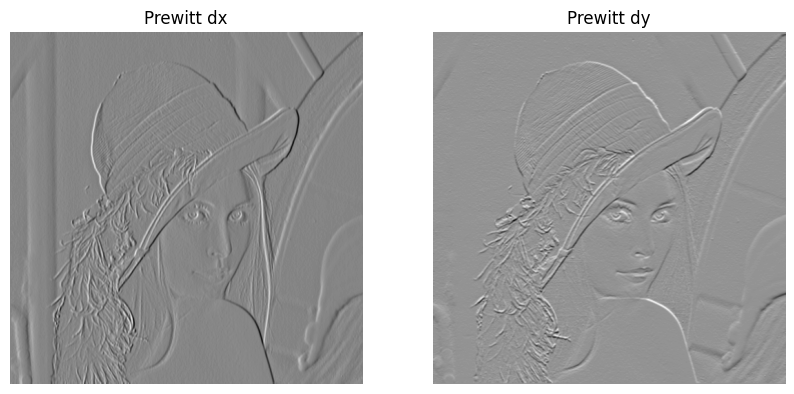

In [14]:
plot_images([(name, img) for name, img in filtered_images_1.items()])

### Comparision with larger filter (5 by 5)

I used the following $5\times5$ filter to produce image dipicting the edges in the original image:

$$

\delta_x = 
\begin{bmatrix}
-1 & -2 & 0 & 2 & 1 \\
-1 & -2 & 0 & 2 & 1 \\
-1 & -2 & 0 & 2 & 1 \\
-1 & -2 & 0 & 2 & 1 \\
-1 & -2 & 0 & 2 & 1
\end{bmatrix}

$$

and,

$$

\delta_y = 
\begin{bmatrix}
-1 & -1 & -1 & -1 & -1 \\
-2 & -2 & -2 & -2 & -2 \\
0 & 0 & 0 & 0 & 0 \\
2 & 2 & 2 & 2 & 2 \\
1 & 1 & 1 & 1 & 1
\end{bmatrix}

$$

Here the 2nd and 2nd last enteries have 

In [15]:
prewitt5_dx = np.array((
    (-1, -2, 0, 2, 1),
    (-1, -2, 0, 2, 1),
    (-1, -2, 0, 2, 1),
    (-1, -2, 0, 2, 1),
    (-1, -2, 0, 2, 1),
)) / 15.

filtered_images_1["5 BY 5 dx"] = filter2d(image_arr, prewitt5_dx)

In [16]:
prewitt5_dy = prewitt5_dx.T

filtered_images_1["5 BY 5 dy"] = filter2d(image_arr, prewitt5_dy)

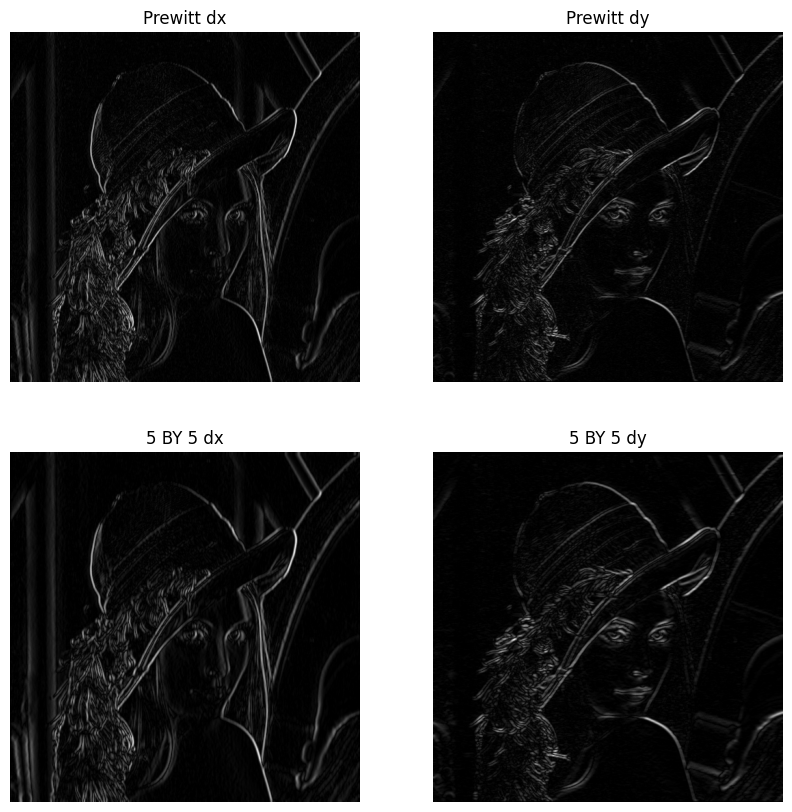

In [17]:
plot_images([(name, arr_to_img(img)) for name, img in filtered_images_1.items()], nrows=2, ncols=2)

### Results

The $\delta_x$ filter detects vertical edges and the $\delta_y$ filter detects horizontal edges. This is happening because the filter computes gradient about the direction mentioned in its subscript.

Few differences observed between different size of filters:

* The edges are thicker in $5\times5$ than in $3\times3$.
* $3\times3$ does a lot better in preserving the hair details.

## Question 2

First we create a dictionary which will be used to store the images that we produce using filters

In [18]:
filtered_images_2 = dict()

### Prewitt filter (3 by 3)

We will use the $3\times3$ Sobel filter to produce image dipicting the edges in the original image:

$$

\delta_x = 
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}

$$

and,

$$

\delta_y = 
\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}

$$

In [19]:
sobel_dx = np.array((
    (-1, 0, 1),
    (-2, 0, 2),
    (-1, 0, 1)
)) / 4.

filtered_images_2["Sobel dx"] = filter2d(image_arr, sobel_dx)

In [20]:
sobel_dy = sobel_dx.T

filtered_images_2["Sobel dy"] = filter2d(image_arr, sobel_dy)

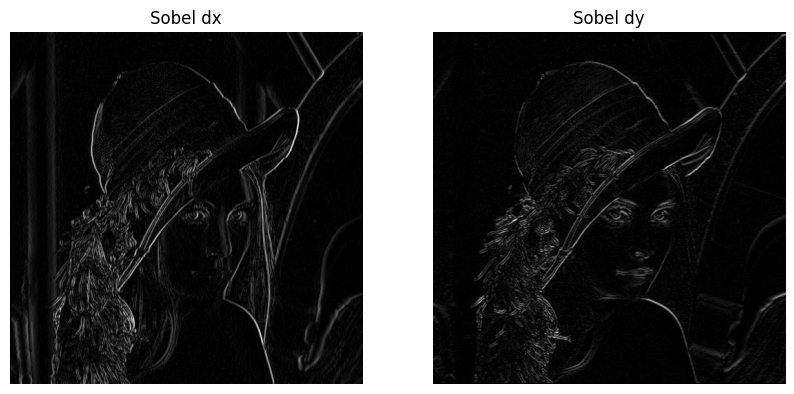

In [21]:
plot_images([(name, arr_to_img(img)) for name, img in filtered_images_2.items()], nrows=1, ncols=2)

### Comparision with larger filter (5 by 5)

We will use following $5\times5$ filter to produce image dipicting the edges in the original image:

$$

\delta_x = 
\begin{bmatrix}
-1 & -2 & 0 & 2 & 1 \\
-2 & -3 & 0 & 3 & 2 \\
-3 & -5 & 0 & 5 & 3 \\
-2 & -3 & 0 & 3 & 2 \\
-1 & -2 & 0 & 2 & 1
\end{bmatrix}

$$

and,

$$

\delta_y = 
\begin{bmatrix}
-1 & -2 & -3 & -2 & -1 \\
-2 & -3 & -5 & -3 & -2 \\
0 & 0 & 0 & 0 & 0 \\
2 & 3 & 5 & 3 & 2 \\
1 & 2 & 3 & 2 & 1
\end{bmatrix}

$$

In [22]:
sobel5_dx = np.array((
    (-1, -2, 0, 2, 1),
    (-2, -3, 0, 3, 2),
    (-3, -5, 0, 5, 3),
    (-2, -3, 0, 3, 2),
    (-1, -2, 0, 2, 1),
)) / 24.

filtered_images_2["5 BY 5 Sobel dx"] = filter2d(image_arr, sobel5_dx)

In [23]:
sobel5_dy = sobel5_dx.T

filtered_images_2["5 BY 5 Sobel dy"] = filter2d(image_arr, sobel5_dy)

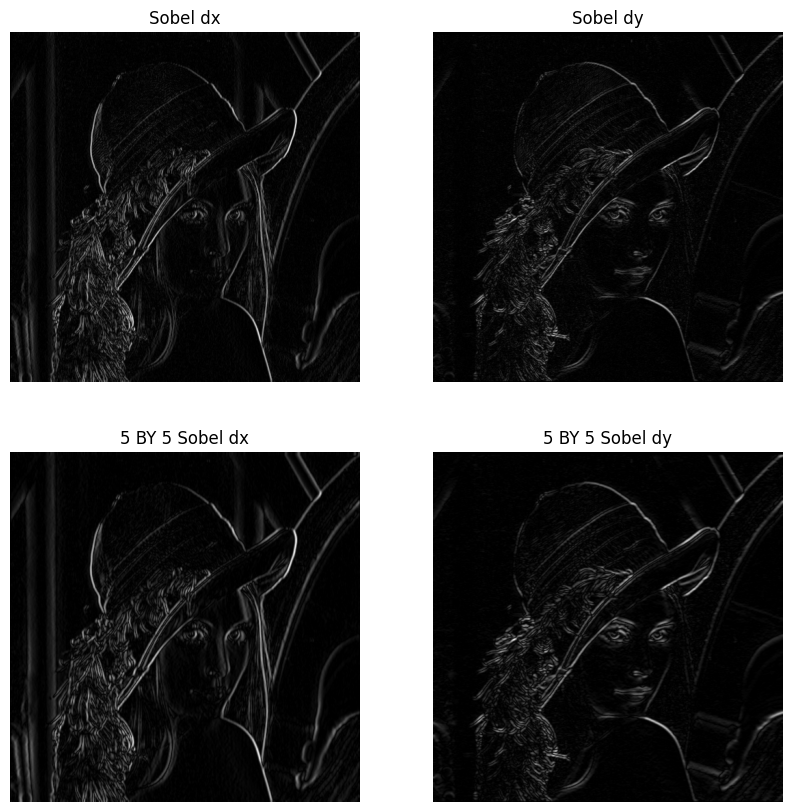

In [24]:
plot_images([(name, arr_to_img(img)) for name, img in filtered_images_2.items()], nrows=2, ncols=2)

### Combining the gradients

We can compute the final gradient using the following formula:

$$
\delta(T) = \sqrt{\delta_x^2 + \delta_y^2}
$$

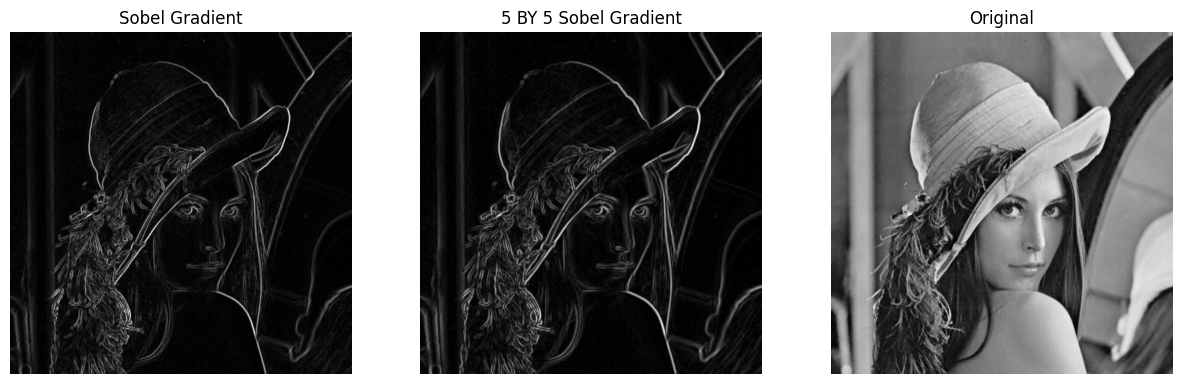

In [25]:
gradients = [
    ("Sobel Gradient", arr_to_img(np.abs(
        filtered_images_2["Sobel dx"] + 1j*filtered_images_2["Sobel dy"]
    ))),
    ("5 BY 5 Sobel Gradient", arr_to_img(np.abs(
        filtered_images_2["5 BY 5 Sobel dx"] + 1j*filtered_images_2["5 BY 5 Sobel dy"]
    ))),
]

plot_images(gradients + [("Original", image)])

### Thresholding

We apply different thresholds to generate the binary image, and compare the results. This is done for both $3\times3$ and $5\times5$ sobel filtered magnitudes.

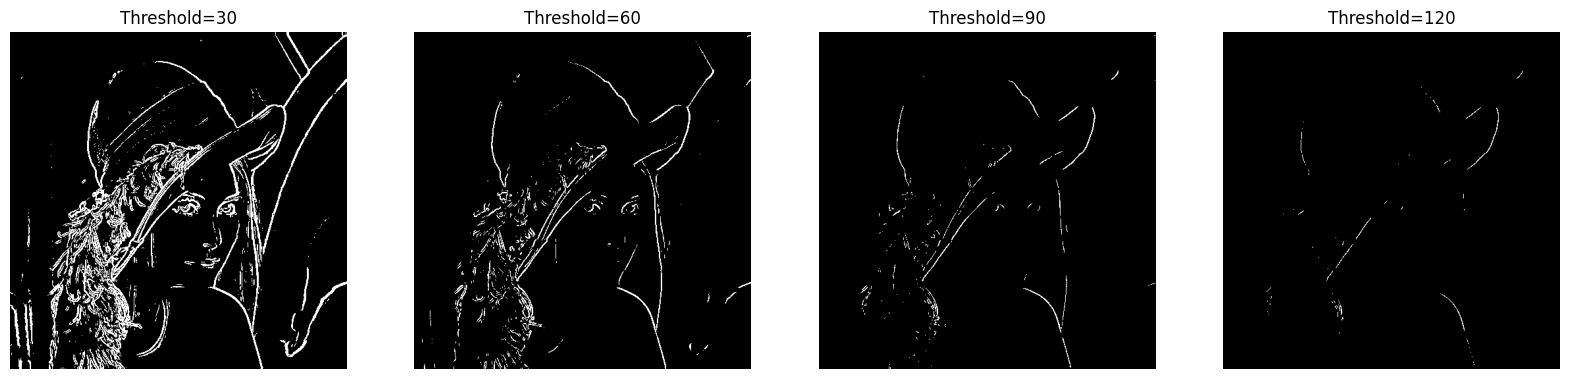

In [26]:
sobel_magnitude = np.abs(filtered_images_2["Sobel dx"] + 1j*filtered_images_2["Sobel dy"])

bin_images = []

for threshold in range(30, 150, 30):
    bin_images.append((
        f"Threshold={threshold}",
        arr_to_img((sobel_magnitude >= threshold)*255)
    ))

plot_images(bin_images)

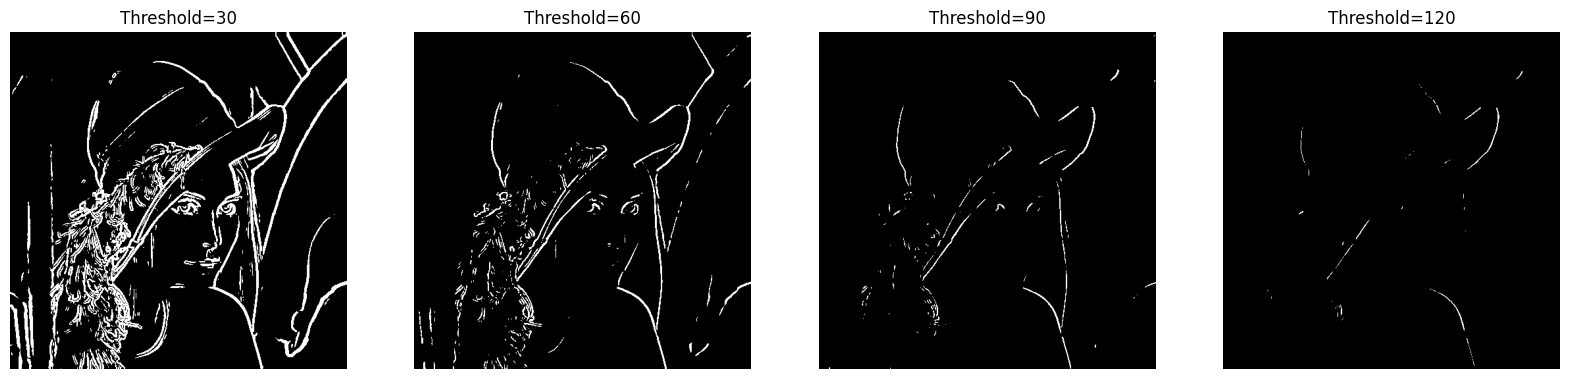

In [27]:
sobel5_magnitude = np.abs(filtered_images_2["5 BY 5 Sobel dx"] + 1j*filtered_images_2["5 BY 5 Sobel dy"])

bin_images = []

for threshold in range(30, 150, 30):
    bin_images.append((
        f"Threshold={threshold}",
        arr_to_img((sobel5_magnitude >= threshold)*255)
    ))

plot_images(bin_images)

### Testing on noisy image

I added normally distributed noise to the image using numpy. Here I have considered different values of sigma for the noise.

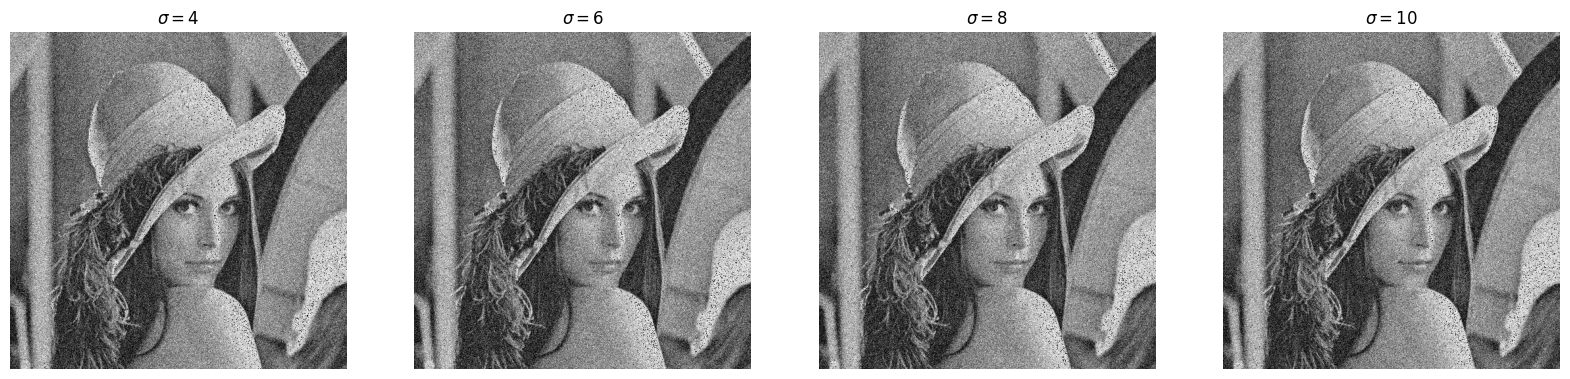

In [28]:
noisy_imgs = []

for i in range(4, 11, 2):
    noisy_imgs.append(arr_to_img(
        image_arr - 6*np.random.normal(0, 5, image_arr.shape)
    ))

plot_images([(f"$\sigma={4 + i*2}$", img) for i, img in enumerate(noisy_imgs)])

then I test Sobel's edge detection method on this noisy image

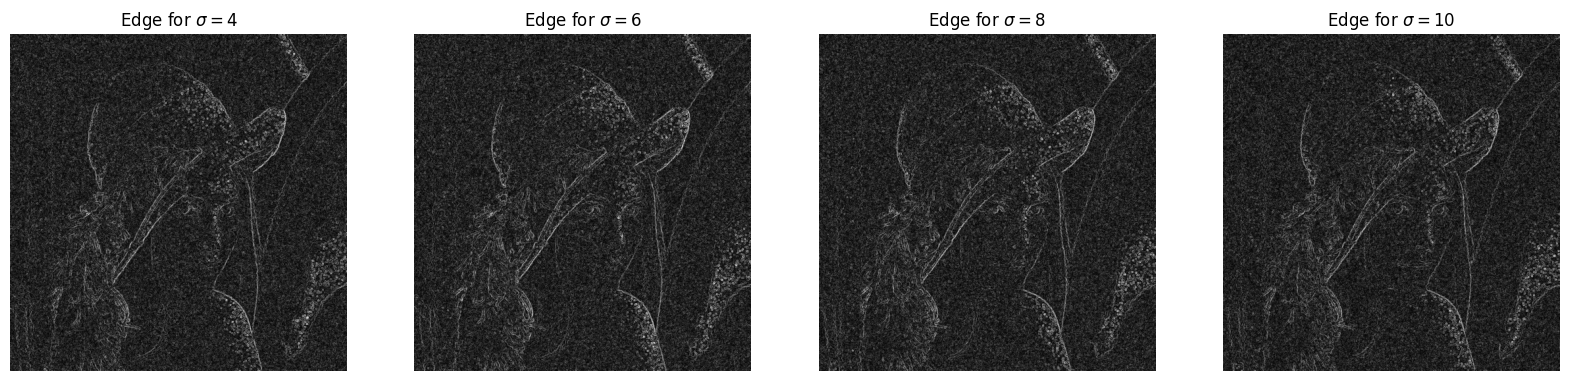

In [29]:
for i, img in enumerate(noisy_imgs):
    filtered_images_2[f"Edge for $\sigma={4 + i*2}$"] = np.abs(
        filter2d(np.array(img), sobel_dx) + 1j*filter2d(np.array(img), sobel_dy)
    )

plot_images([(name, arr_to_img(img)) for name, img in filtered_images_2.items() if "Edge" in name])

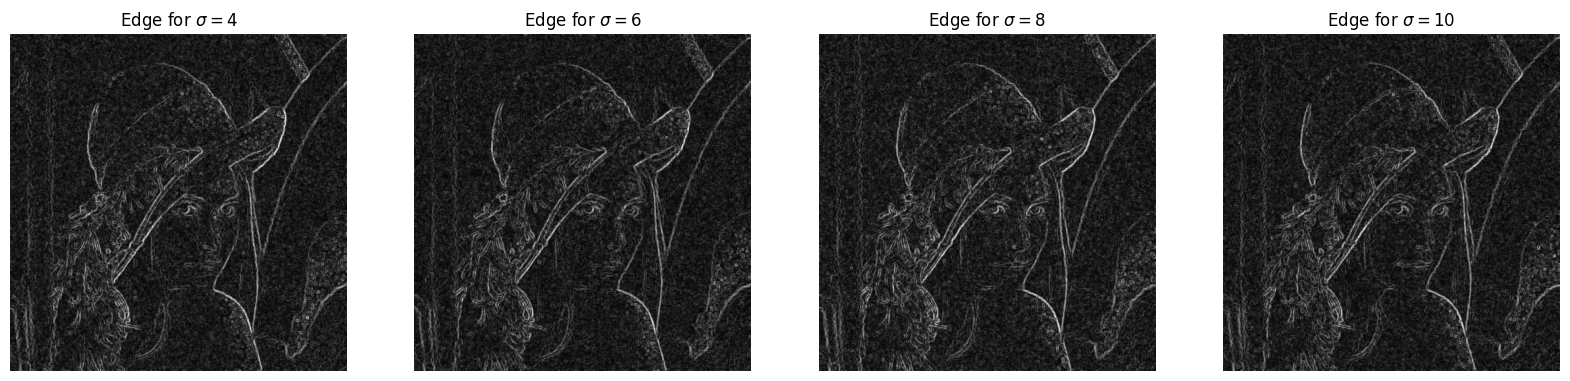

In [30]:
for i, img in enumerate(noisy_imgs):
    filtered_images_2[f"Edge for $\sigma={4 + i*2}$"] = np.abs(
        filter2d(np.array(img), sobel5_dx) + 1j*filter2d(np.array(img), sobel5_dy)
    )

plot_images([(name, arr_to_img(img)) for name, img in filtered_images_2.items() if "Edge" in name])

# Question 3

In [31]:
filtered_images_3 = dict()

In [32]:
gaussian = np.array((
    (1, 2, 1),
    (2, 4, 2),
    (1, 2, 1)
)) / 16.

filtered_images_3["Gaussian Blurred"] = filter2d(image_arr, gaussian)

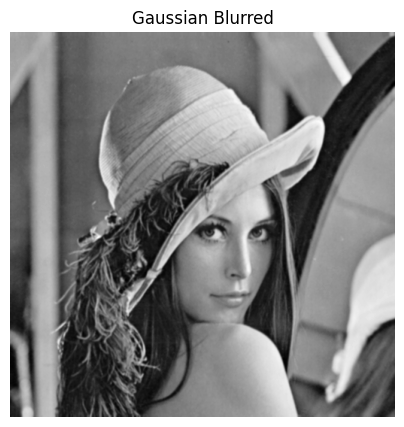

In [33]:
plot_images([(name, arr_to_img(img)) for name, img in filtered_images_3.items()])

In [34]:
laplacian = np.array((
    (0, 1, 0),
    (1,-4, 1),
    (0, 1, 0)
))

filtered_images_3["Laplacian"] = filter2d(image_arr, laplacian)
filtered_images_3["Laplacian (0 mapped to 128)"] =  filtered_images_3["Laplacian"] + 128

### Zero crossing

The way I implemented zero crossing here is for each pixel value $P_{i,j}$ I am checking if the sign is changed from previous pixels, that is $P_{i-1,j}$ and $P_{i,j-1}$. If the sign is changed then I am marking that pixel as edge pixel if the change between the pixels is greater than a certain threshold given to the function of zero crossing I have implemented.

In [35]:
@jit(nopython=True)
def zero_crossing(lap_img : np.ndarray, threshold = 25) -> np.ndarray:
    '''
    This function returns a binary image with whites values depicting zero crossing

    ref: https://stackoverflow.com/questions/61836022/how-to-find-zero-crossings-in-the-laplacian-of-gaussian-of-an-image
    '''

    bin_img = np.zeros(lap_img.shape, dtype=np.uint8)

    for i in range(1, lap_img.shape[0] - 1):
        for j in range(1, lap_img.shape[1] - 1):

            if lap_img[i, j] * lap_img[i-1, j] < 0:
                if np.abs(lap_img[i, j] - lap_img[i-1, j]) > threshold:
                    bin_img[i, j] = 1
                    continue

            if lap_img[i, j] * lap_img[i, j-1] < 0:
                if np.abs(lap_img[i, j] - lap_img[i, j-1]) > threshold:
                    bin_img[i, j] = 1
                    continue

    return bin_img

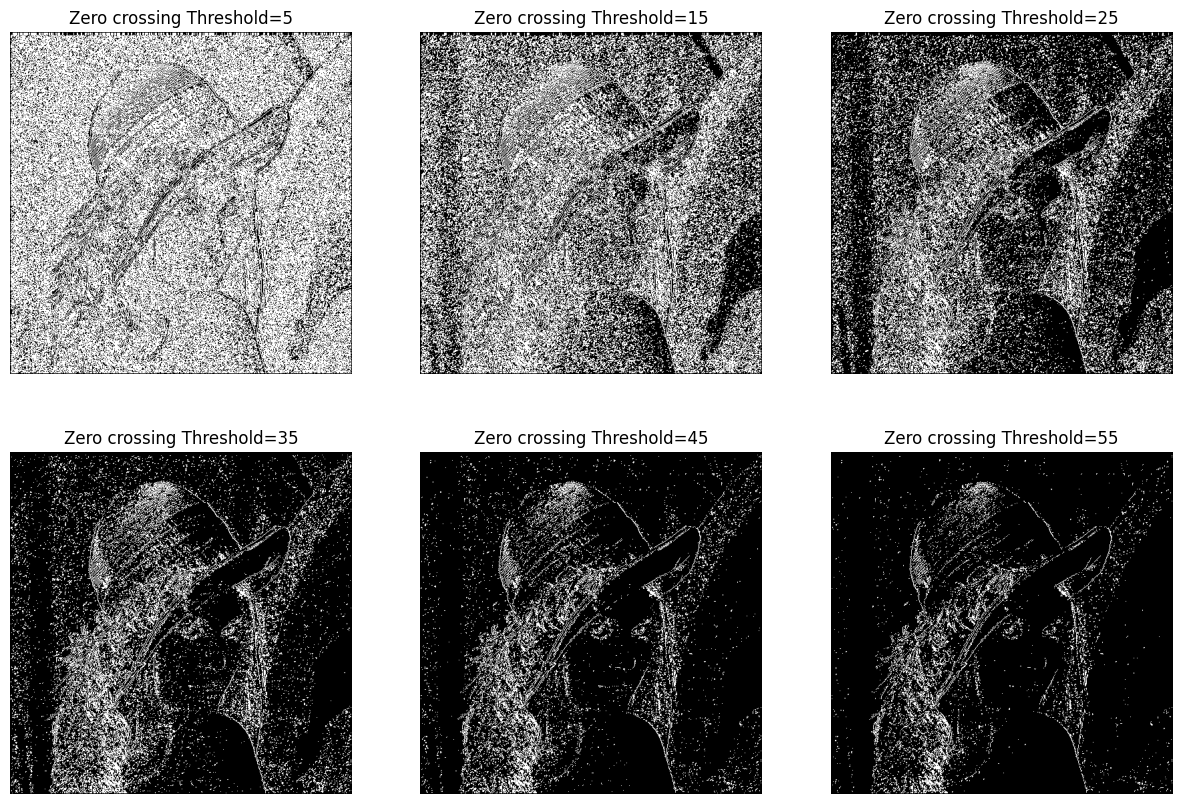

In [36]:
zero_crossed_imgs = []

for threshold in range(5, 56, 10):
    zero_crossed_imgs.append((
        f"Zero crossing Threshold={threshold}",
        arr_to_img(zero_crossing(filtered_images_3["Laplacian"], threshold)*255)
    ))

plot_images(zero_crossed_imgs, nrows=2, ncols=3)

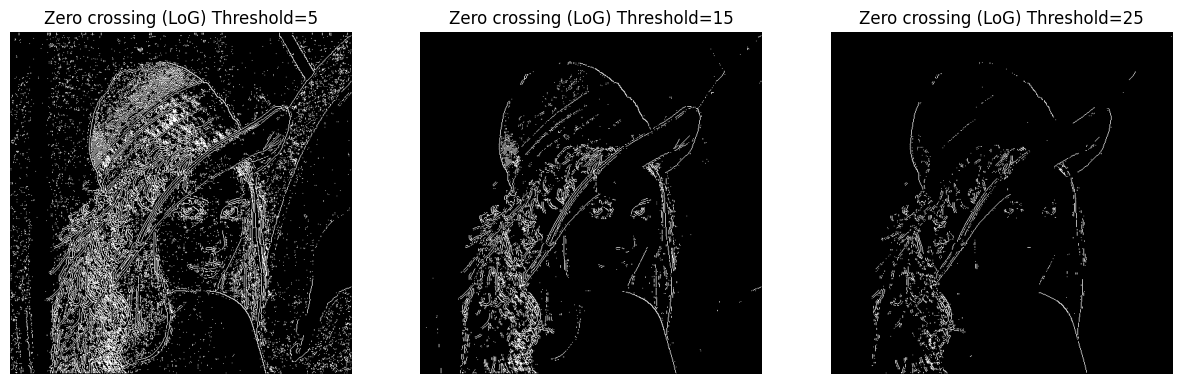

In [37]:
zero_crossed_imgs_lod = []

filtered_images_3["LoG"] = filter2d(filtered_images_3["Gaussian Blurred"], laplacian)
filtered_images_3["LoG (0 mapped to 128)"] = filtered_images_3["LoG"] + 128

for threshold in range(5, 26, 10):
    zero_crossed_imgs_lod.append((
        f"Zero crossing (LoG) Threshold={threshold}",
        arr_to_img(zero_crossing(filtered_images_3["LoG"], threshold)*255)
    ))

plot_images(zero_crossed_imgs_lod, nrows=1, ncols=3)

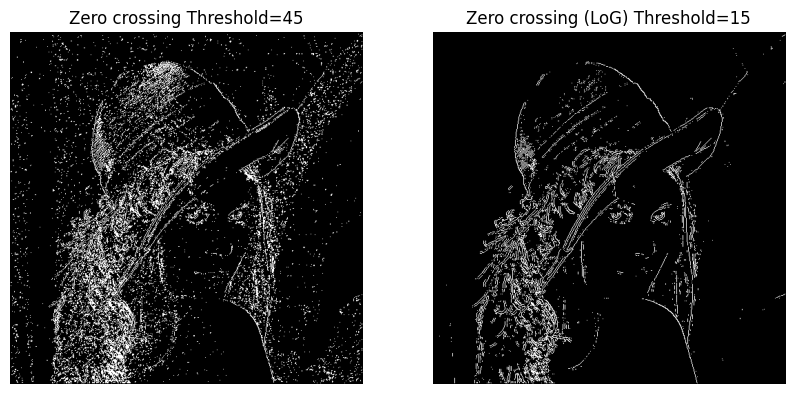

In [38]:
plot_images([zero_crossed_imgs[4]]+[zero_crossed_imgs_lod[1]])

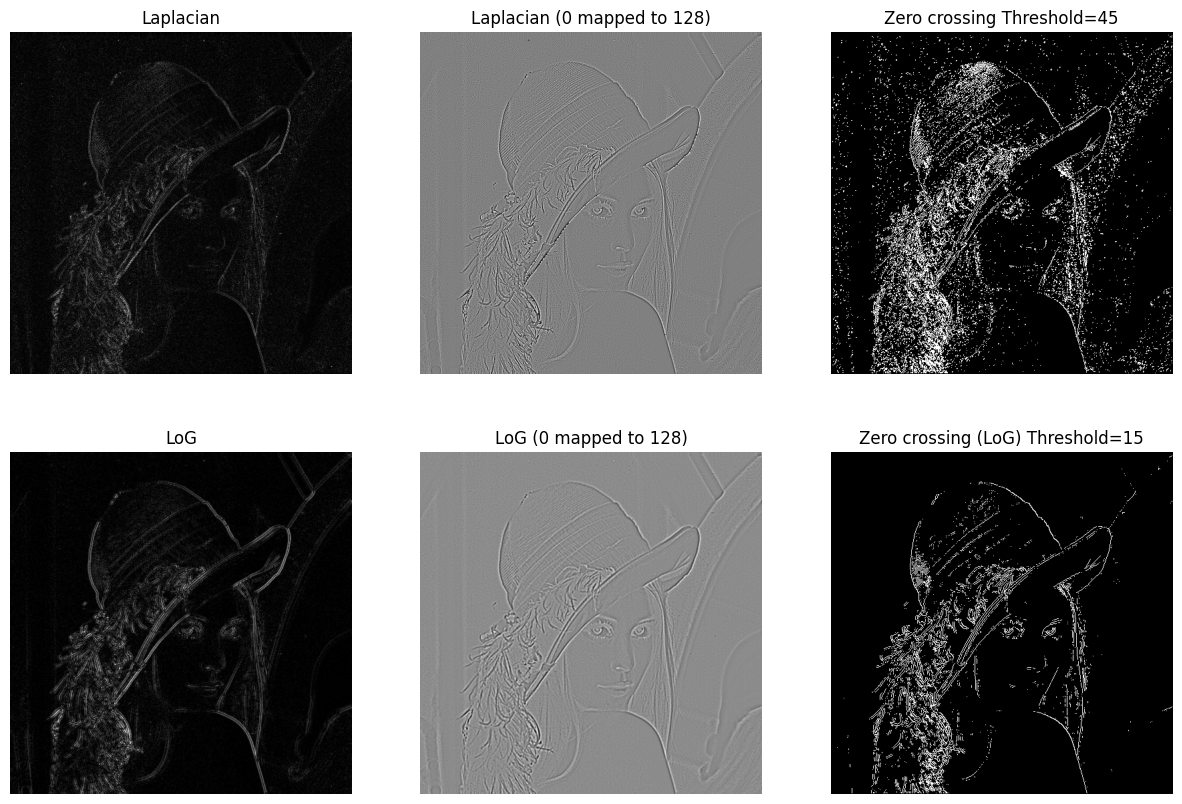

In [39]:
plot_images([
    ("Laplacian", arr_to_img(filtered_images_3["Laplacian"])),
    ("Laplacian (0 mapped to 128)", arr_to_img(filtered_images_3["Laplacian (0 mapped to 128)"])),
    zero_crossed_imgs[4],
    ("LoG", arr_to_img(filtered_images_3["LoG"])),
    ("LoG (0 mapped to 128)", arr_to_img(filtered_images_3["LoG (0 mapped to 128)"])),
    zero_crossed_imgs_lod[1]
], nrows=2, ncols=3)